## Deep Food Algorithm by Ifeanyi Anthony Omeifejideofor

* The Aim of this project is build Deep Learning Algorithm to detect 101 different classes of food.

* The dataset is gotten from https://www.tensorflow.org/datasets/catalog/food101

* The dataset contains 75,750 training images and 25,250 testing images.

* The goal of the project is beat the deep food paper published in 2016 https://bit.ly/Deep_paper, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy


## Checking if GPU compatible with mixed precision training

In [1]:
!nvidia-smi -L

#The allocated GPU is not compactible with Mixed precsion training

GPU 0: Tesla T4 (UUID: GPU-00005d00-9d3c-7a72-0397-08d6d4e584f9)


In [2]:
## Import function 
!pip install tensorhelper

  Created wheel for tensorhelper: filename=tensorhelper-0.1.9-py3-none-any.whl size=5091 sha256=9fe1faaec19274eeb038b8475c379f3eac7cb2927e9c7d7f72c94dabd1e1d976
  Stored in directory: /root/.cache/pip/wheels/98/bb/dd/c163c16ca7dbfd4073fcc58e431d071e2cbbb98f4e935f6eaa
Successfully built tensorhelper


In [3]:
## Import helper function which i created earlier to help with building deep learning Algorithm
from tensorhelper.custom_tensor import image_reader
from tensorhelper.custom_tensor import plot_generator
from tensorhelper.custom_tensor import load_custom_images
from tensorhelper.custom_tensor import make_confusion_matrix
from tensorhelper.custom_tensor import create_tensorboard_callback
from tensorhelper.custom_tensor import create_tensorhub_model
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

I built a PIP python Package called "Tensorflow Helper". These are sets of hyper functions to help making building the deep learning model easier.

https://pypi.org/project/tensorhelper/

## Downloading Dataset from Tensorflow Dataset

In [4]:
(train_data, test_data), with_info = tfds.load('food101', split=['train', 'validation'], 
                                               shuffle_files=True, with_info = True,
                                               as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteNGYMRG/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteNGYMRG/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [5]:
with_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

## Exploring the Data

In [6]:
train_data_one = train_data.take(1)

In [7]:
train_data_one

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [8]:
class_names = with_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
for image, label in train_data_one:
  print(f"""
      images: {image.shape}
      image_datatype: {image.dtype}
      image_label: {label}
      image_class:{class_names[label.numpy()]}
      """
  )


      images: (512, 512, 3)
      image_datatype: <dtype: 'uint8'>
      image_label: 43
      image_class:fried_calamari
      


In [10]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=43>

In [11]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[71, 60, 56],
        [70, 59, 55],
        [70, 59, 55],
        ...,
        [65, 60, 67],
        [65, 60, 67],
        [64, 59, 66]],

       [[62, 51, 47],
        [64, 53, 49],
        [66, 55, 51],
        ...,
        [65, 60, 67],
        [65, 60, 67],
        [64, 59, 66]],

       [[61, 50, 46],
        [65, 54, 50],
        [68, 57, 53],
        ...,
        [66, 61, 68],
        [65, 60, 67],
        [63, 58, 65]],

       ...,

       [[63, 64, 66],
        [64, 65, 67],
        [67, 67, 69],
        ...,
        [45, 42, 49],
        [45, 42, 49],
        [45, 42, 49]],

       [[64, 64, 66],
        [64, 64, 66],
        [65, 65, 67],
        ...,
        [44, 41, 48],
        [44, 41, 48],
        [44, 41, 48]],

       [[62, 62, 64],
        [62, 62, 64],
        [62, 62, 64],
        ...,
        [43, 40, 47],
        [42, 39, 46],
        [42, 39, 46]]], dtype=uint8)>

In [12]:
tf.reduce_max(image), tf.reduce_min(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=255>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=0>)

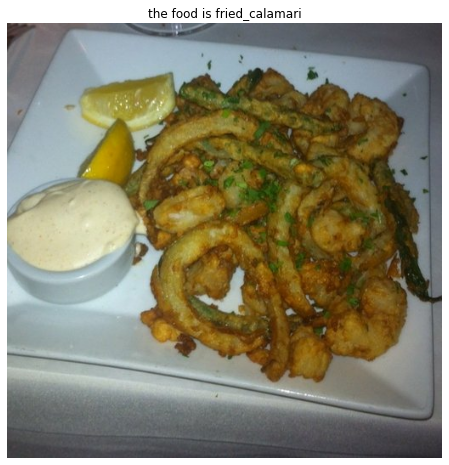

In [13]:
## Plotting the Image for our Machine Learning model

plt.figure(figsize = (12, 8))
plt.imshow(image)
plt.title(f'the food is {class_names[label.numpy()]}')
plt.axis(False);

## Create preprocessing functions for our data

In [14]:
#Preprocessing our data.

def preprocessed_data(image, label, image_shape = 224):
  image = tf.image.resize(image, [image_shape, image_shape])
  #image = image/255. scaling or normalizing images
  return tf.cast(image, tf.float32), label #returns a tuple of images and labels

In [15]:
preprocessed_data(image, label)[0]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 65.811226,  54.811222,  50.811222],
        [ 73.331635,  62.331635,  58.331635],
        [104.015305,  89.80102 ,  86.80102 ],
        ...,
        [ 61.85712 ,  59.071384,  65.64286 ],
        [ 65.      ,  60.      ,  67.      ],
        [ 64.64282 ,  59.642822,  66.64282 ]],

       [[ 67.28571 ,  56.285717,  52.285717],
        [ 66.47449 ,  55.47449 ,  51.47449 ],
        [ 67.73979 ,  53.525505,  50.525505],
        ...,
        [ 64.14284 ,  61.3571  ,  67.92857 ],
        [ 65.93368 ,  60.933674,  67.93368 ],
        [ 64.285645,  59.285645,  66.285645]],

       [[ 58.214287,  47.214287,  43.214287],
        [ 60.867348,  46.867348,  43.867348],
        [ 71.03062 ,  55.89286 ,  52.938778],
        ...,
        [ 62.999977,  60.382614,  66.61734 ],
        [ 65.05613 ,  60.056133,  66.84185 ],
        [ 64.36218 ,  59.362183,  66.147896]],

       ...,

       [[ 64.43876 ,  65.43876 ,  67.43876 ],
        [ 66.

## Batching and Preparing Data

In [16]:
#Batching and preparing train data
train_data = train_data.map(preprocessed_data, num_parallel_calls= tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

#Batching and preparing test data
test_data = test_data.map(preprocessed_data, num_parallel_calls= tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [17]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=1) # don't print out whether or not model is being save

#Create Earlystopping callback to prevent model from training when accuracy cease increasing or reduces to prevent Over fitting                                                     
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

In [18]:
# Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. 
#This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
                                          monitor='val_loss',
                                          factor=0.2,
                                          patience=2,
                                          verbose = 1,
                                          min_lr=1e-7)

In [19]:
#Create a data Augmentation layer for our functional API deep learning neural networks.
data_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip(mode = 'horizontal'),
      tf.keras.layers.RandomRotation(0.2)                                   
])

## Building A Deep Learning Algorithm using the Functional API

In [20]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False)

base_model.trainable = False

inputs = tf.keras.Input(shape = (224, 224, 3))

data_aug = data_augmentation(inputs, training = False)

x = base_model(data_aug)

x = tf.keras.layers.GlobalAveragePooling2D(name = 'Pooling_Layer')(x)

outputs = tf.keras.layers.Dense(101, activation = 'softmax', name = 'Output_layer')(x)

deep_food_101 = tf.keras.Model(inputs, outputs)


#Compile the model
deep_food_101.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [21]:
# Fit the model with callbacks
history1= deep_food_101.fit(train_data, 
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=int(0.15 * len(test_data)),
                                  callbacks=[create_tensorboard_callback("training_logs", 
                                                                      "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint,
                                                                early_stopping])

 Saving tensorboard files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220507-083136
Epoch 1/5
2368/2368 [==============================] - ETA: 0s - loss: 1.8809 - accuracy: 0.5424
Epoch 1: val_accuracy improved from -inf to 0.67240, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 173s 66ms/step - loss: 1.8809 - accuracy: 0.5424 - val_loss: 1.2367 - val_accuracy: 0.6724
Epoch 2/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.3693 - accuracy: 0.6480
Epoch 2: val_accuracy improved from 0.67240 to 0.69915, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 159s 67ms/step - loss: 1.3692 - accuracy: 0.6480 - val_loss: 1.1322 - val_accuracy: 0.6992
Epoch 3/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.2274 - accuracy: 0.6792
Epoch 3: val_accuracy improved from 0.69915 to 0.71213, saving model to model_checkpoints/cp.ckpt
2368/2368 [=======================

In [22]:
original_model = deep_food_101.evaluate(test_data)
original_model

790/790 [==============================] - 47s 60ms/step - loss: 1.0602 - accuracy: 0.7127


[1.0601896047592163, 0.7127128839492798]

In [23]:
deep_food_101.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Pooling_Layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 Output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

## fine Tuning the Feature Extraction Model

In [24]:
base_model.trainable = True

for layer in base_model.layers[:-20]:
  layer.trainable = False

In [25]:
# Unfreezing the bottom 30 layers in the efficientB0 Deep learning Neural Network
for numbers, layers in enumerate(deep_food_101.layers[2].layers):
  print(numbers, layers.name, layers.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [26]:
#Compile the model
deep_food_101.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [27]:
# Fit the model with callbacks
history2= deep_food_101.fit(train_data, 
                                  epochs=25,
                                  initial_epoch =5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=int(0.15 * len(test_data)),
                                  callbacks=[create_tensorboard_callback("training_logs", 
                                                                      "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                early_stopping,
                                                               reduce_learning_rate])

 Saving tensorboard files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220507-084647
Epoch 6/25
2368/2368 [==============================] - 181s 73ms/step - loss: 1.3009 - accuracy: 0.6570 - val_loss: 0.9070 - val_accuracy: 0.7489 - lr: 0.0010
Epoch 7/25
2368/2368 [==============================] - 174s 73ms/step - loss: 0.9510 - accuracy: 0.7404 - val_loss: 0.8796 - val_accuracy: 0.7556 - lr: 0.0010
Epoch 8/25
2368/2368 [==============================] - 175s 73ms/step - loss: 0.7531 - accuracy: 0.7903 - val_loss: 0.9065 - val_accuracy: 0.7548 - lr: 0.0010
Epoch 9/25
2367/2368 [============================>.] - ETA: 0s - loss: 0.5902 - accuracy: 0.8314
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2368/2368 [==============================] - 175s 73ms/step - loss: 0.5901 - accuracy: 0.8314 - val_loss: 0.8885 - val_accuracy: 0.7651 - lr: 0.0010
Epoch 10/25
2368/2368 [==============================] - 175s 73ms/step - loss: 0.29

In [28]:
def compare_plot(old_history, new_history, initial_epochs = 10):

  acc= old_history.history['accuracy'] + new_history.history['accuracy']
  val_acc = old_history.history['val_accuracy'] + new_history.history['val_accuracy']

  loss = old_history.history['loss'] + new_history.history['loss']
  val_loss = old_history.history['val_loss'] + new_history.history['val_loss']

  fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex = True, figsize = (10, 8))


  fig, ax1.plot(acc, label = 'Training Accuracy')
  fig, ax1.plot(val_acc, label = 'Validation Accuracy')
  fig, ax1.plot([initial_epochs -1, initial_epochs-1], plt.ylim(), label = 'start fine tuning')
  fig, ax1.set_title('Training Accuracy curve of our deep neural network')
  fig, ax1.legend();


  fig, ax2.plot(loss, label = 'Training Loss')
  fig, ax2.plot(val_loss, label = 'Validation loss')
  fig, ax2.plot([initial_epochs -1, initial_epochs-1], plt.ylim(), label = 'start fine tuning')
  fig, ax2.set_title('Training Loss curve our deep neural network')
  fig, ax2.set_xlabel('epochs')
  fig, ax2.legend();

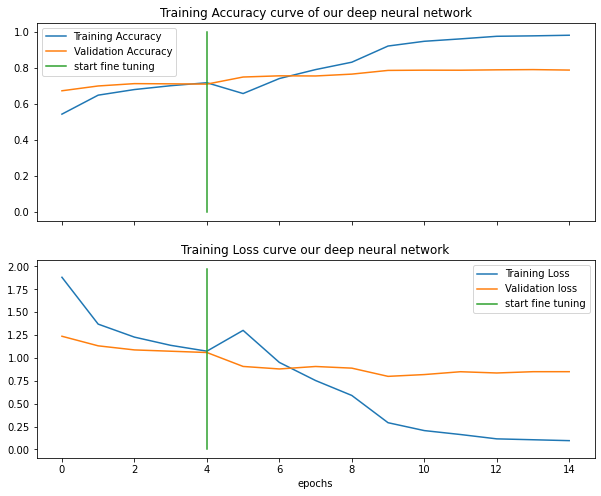

In [29]:
compare_plot(history1, history2, initial_epochs= 5)

From the chart you can visualize the model performance before and After I fine tuned the Model. The model performed relatively better after I fined tuned the model.

In [30]:
deep_food_101.evaluate(test_data)

790/790 [==============================] - 46s 59ms/step - loss: 0.8372 - accuracy: 0.7914


[0.8371749520301819, 0.7914059162139893]

The  model beat the results mentioned in the DeepFood paper for Food101 (DeepFood's algorithm 77.4% top-1 accuracy versus my Algorithm ~79.14% top-1 accuracy).

## Although My model got a 79.14% accuracy. An Earlier Model I trained had 79.28% Accuracy model hence I will be importing my earlier Model and using various classification matrixes e.g Accuracy,Confusion Matrix and Classification Report to test it's performance

In [45]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Google Earth/food_101_bestmodel')

In [46]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 48s 59ms/step - loss: 0.8307 - accuracy: 0.7928


[0.8306736350059509, 0.7928316593170166]

In [47]:
prediction = loaded_model.predict(test_data)

In [48]:
pred_data = []

for item in prediction:
  pred_data.append(item.argmax())

pred_data[:5]

[78, 100, 79, 4, 37]

In [49]:
true_label = []

for image, label in test_data.unbatch():
  true_label.append(label.numpy())

In [50]:
true_label[:5]

[1, 75, 61, 74, 54]

In [51]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
                          """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

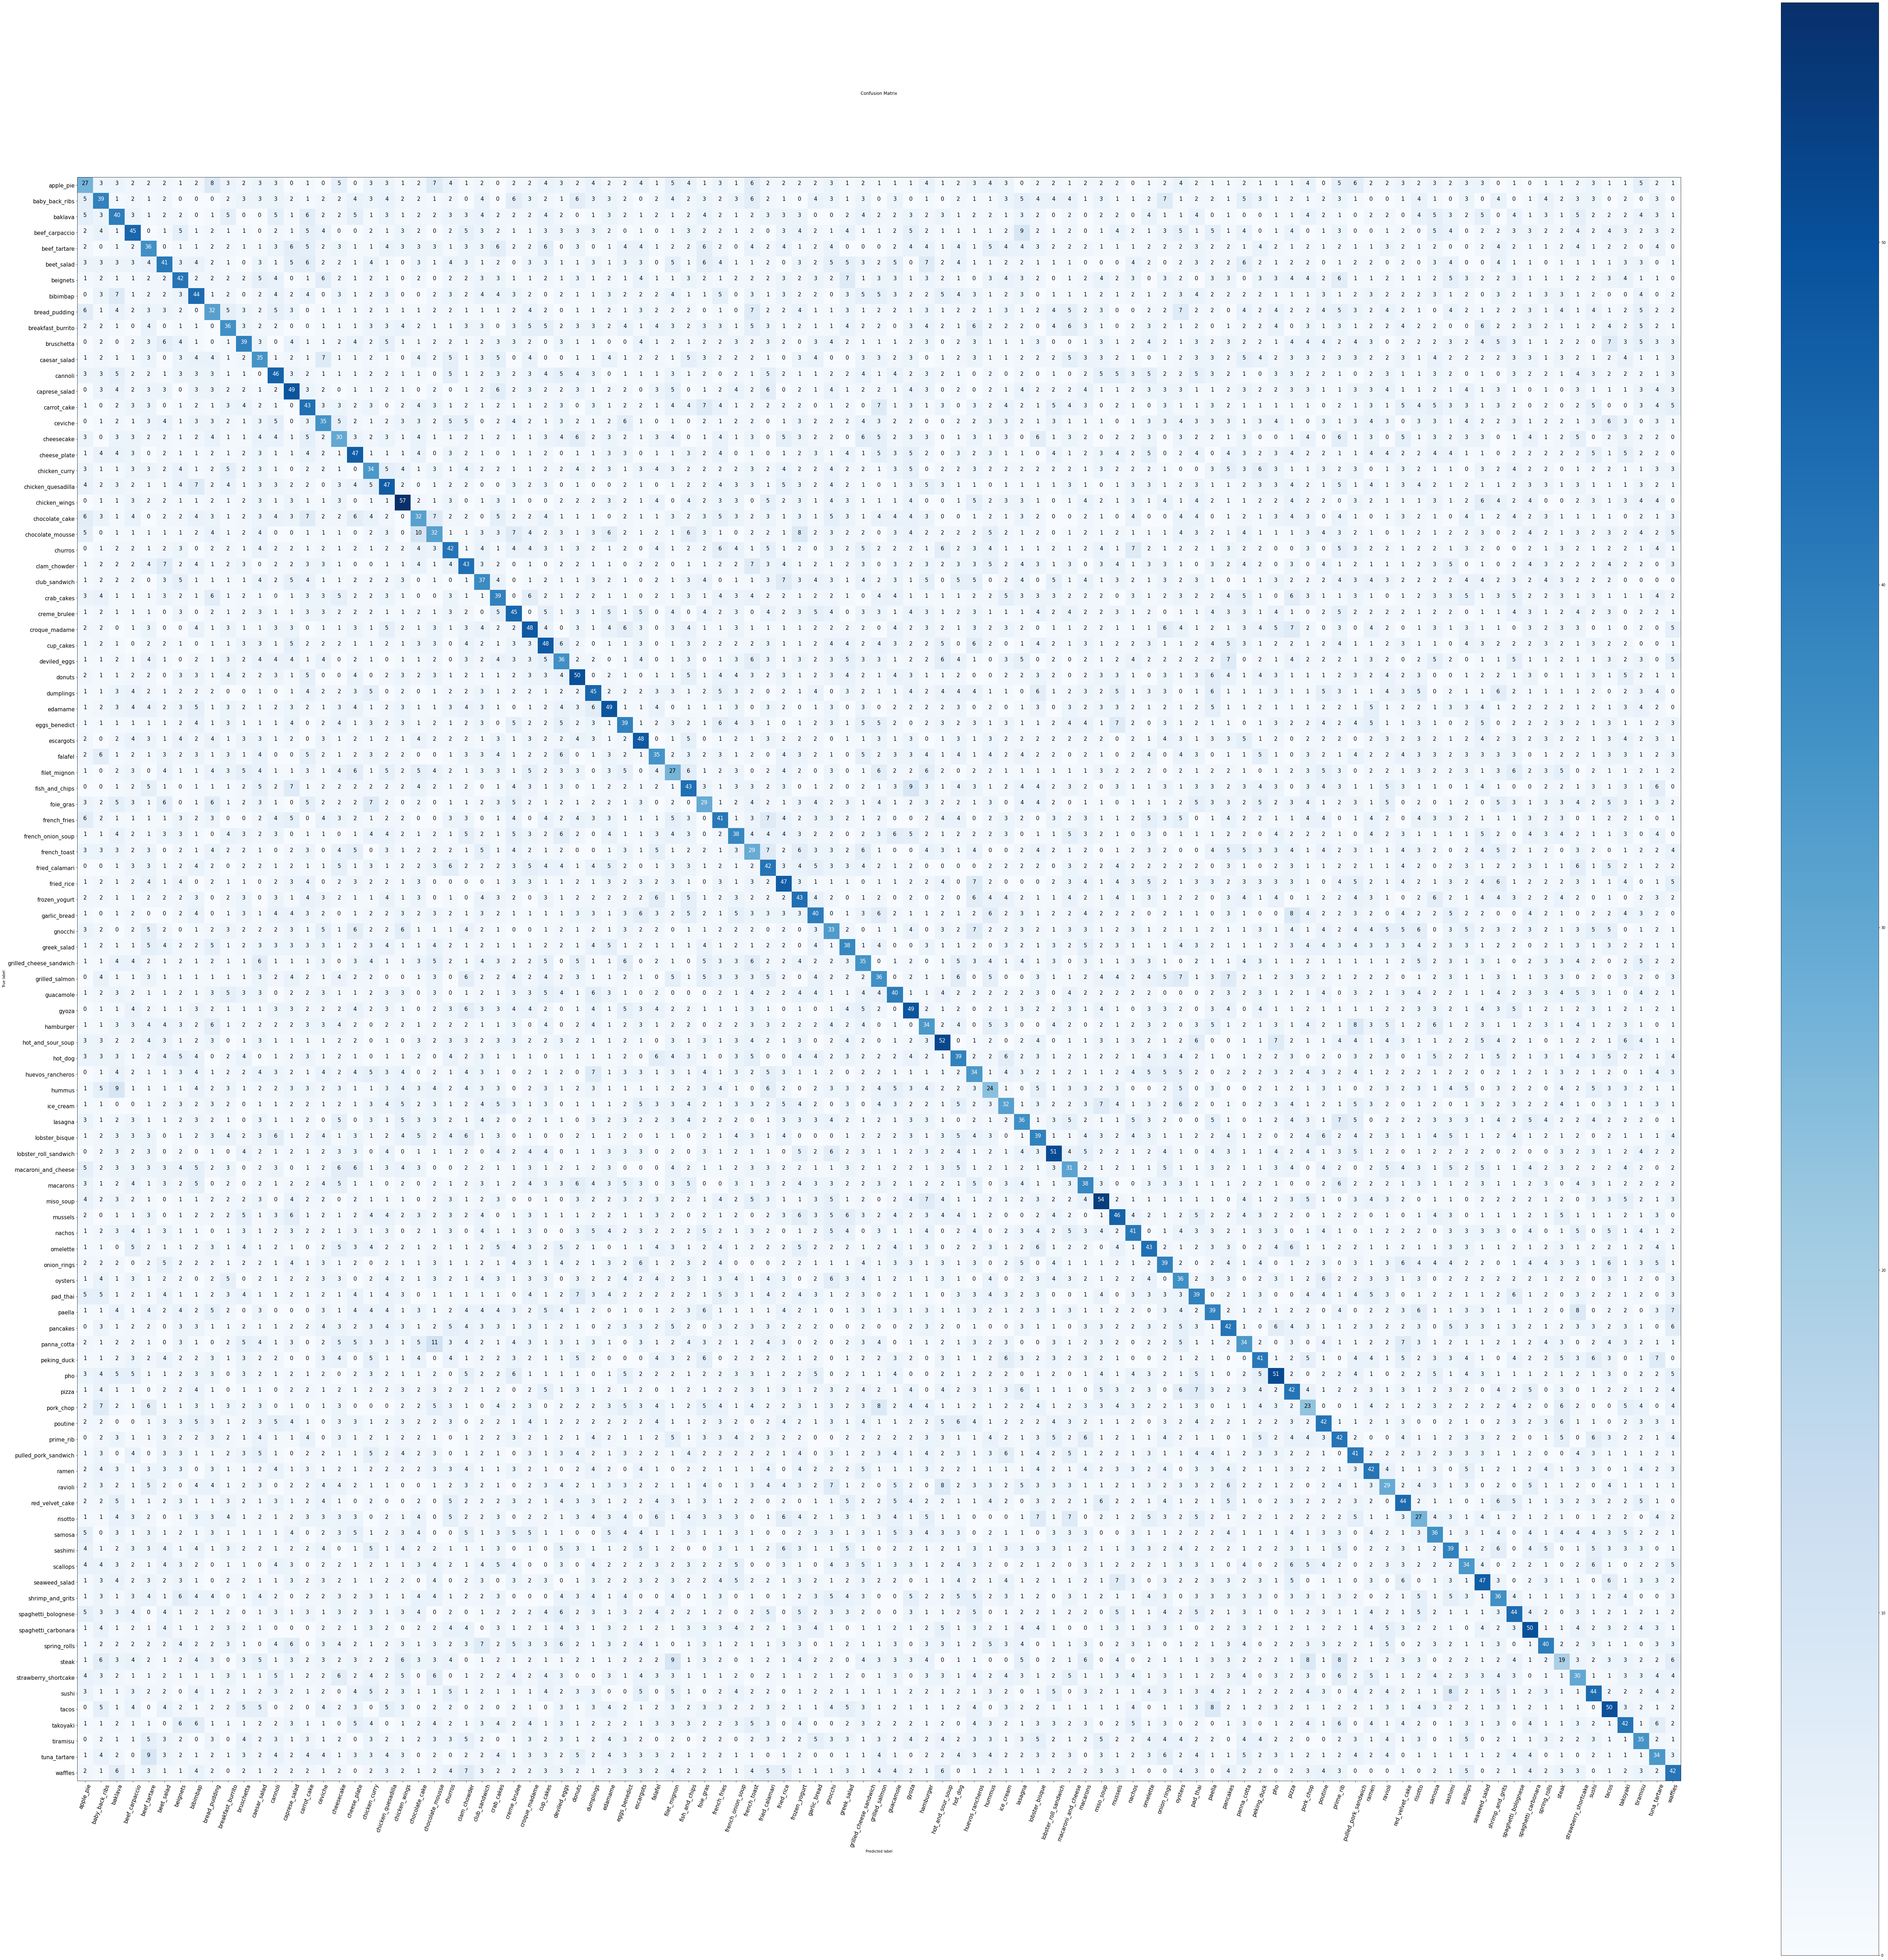

In [52]:
make_confusion_matrix(y_true =true_label, y_pred = pred_data, classes = class_names, figsize = (100, 100))

## Saving the Model and Visualizing Outcome

In [60]:
test_data_view = test_data.unbatch().take(10)

In [61]:
for image_test_data, label_test_data in test_data_view:
  print(f"""
      images: {image_test_data.shape}
      image_datatype: {image_test_data.dtype}
      image_label: {label_test_data}
      """
  )


      images: (224, 224, 3)
      image_datatype: <dtype: 'float32'>
      image_label: 37
      

      images: (224, 224, 3)
      image_datatype: <dtype: 'float32'>
      image_label: 99
      

      images: (224, 224, 3)
      image_datatype: <dtype: 'float32'>
      image_label: 40
      

      images: (224, 224, 3)
      image_datatype: <dtype: 'float32'>
      image_label: 60
      

      images: (224, 224, 3)
      image_datatype: <dtype: 'float32'>
      image_label: 1
      

      images: (224, 224, 3)
      image_datatype: <dtype: 'float32'>
      image_label: 69
      

      images: (224, 224, 3)
      image_datatype: <dtype: 'float32'>
      image_label: 52
      

      images: (224, 224, 3)
      image_datatype: <dtype: 'float32'>
      image_label: 62
      

      images: (224, 224, 3)
      image_datatype: <dtype: 'float32'>
      image_label: 77
      

      images: (224, 224, 3)
      image_datatype: <dtype: 'float32'>
      image_label: 67
      


In [62]:
## Creating a list of images and labels to view our prediction
check_image = [ ]
check_label = [ ]
for image_test_data, label_test_data in test_data_view:
  check_image.append(image_test_data)
  check_label.append(label_test_data.numpy())

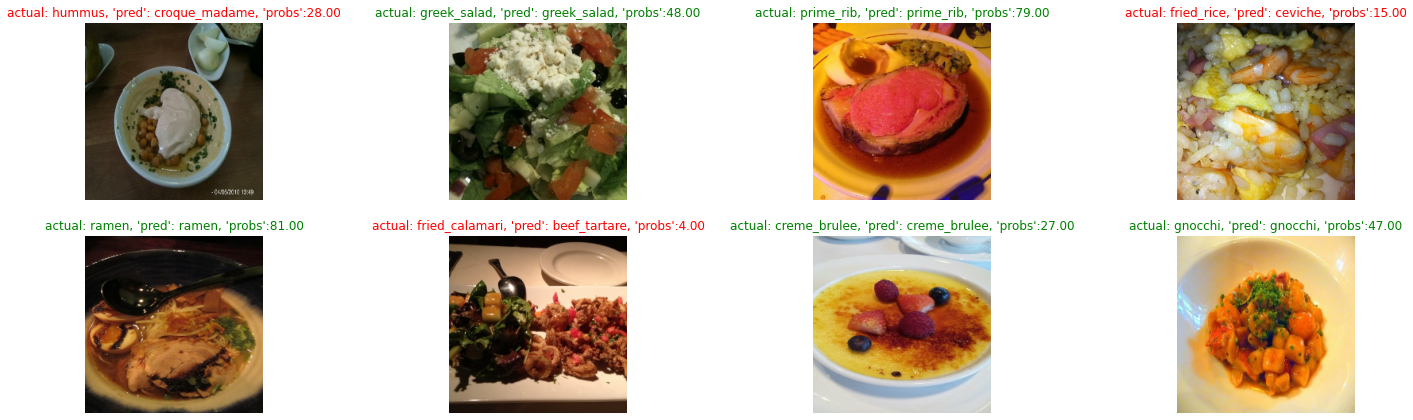

In [63]:
import os
import random

image_shape = 224

plt.figure(figsize = (25, 15))
for i in range(8):
  plt.subplot(4, 4, i+1)

  #passing our image through the read image function to scale and normalize image.
  image = check_image[i]
  pred_img = loaded_model.predict(tf.expand_dims((image),axis = 0))
  predict_class = class_names[pred_img.argmax()]
  actual_label = class_names[check_label[i]]
  
  if actual_label == predict_class:
    title_colour = 'green'
  else:
    title_colour = 'red'

  plt.title(f"actual: {actual_label}, 'pred': {predict_class}, 'probs':{pred_img.argmax():.2f}", color = title_colour)
  plt.imshow(image/255)
  plt.axis(False);

## The Deep Food Model with a 79.28% Accuracy got 6 of the 8 prediction correct and 2 of the prediction wrong.

In [65]:
from sklearn.metrics import classification_report

#calculating classification report our dataset
classification_score = classification_report(y_true =true_label, y_pred = pred_data, output_dict = True)

In [66]:
import pandas as pd

classification_score_pd = pd.DataFrame.from_dict(classification_score).transpose()
classification_score_pd.drop(['accuracy', 'macro avg', 'weighted avg' ], inplace = True)

In [67]:
classification_score_pd

,precision,recall,f1-score,support
0,0.126168,0.108,0.116379,250.0
1,0.154762,0.156,0.155378,250.0
2,0.155039,0.160,0.157480,250.0
3,0.177165,0.180,0.178571,250.0
4,0.142857,0.144,0.143426,250.0
...,...,...,...,...
96,0.192308,0.200,0.196078,250.0
97,0.170732,0.168,0.169355,250.0
98,0.144033,0.140,0.141988,250.0
99,0.144068,0.136,0.139918,250.0


In [68]:
classification_dict = {}

for key, values in classification_score.items():
  if key == 'accuracy':
    break
  else:
    classification_dict[class_names[int(key)]] = values['f1-score']

In [69]:
classification_dict

{'apple_pie': 0.11637931034482757,
 'baby_back_ribs': 0.15537848605577687,
 'baklava': 0.15748031496062992,
 'beef_carpaccio': 0.17857142857142858,
 'beef_tartare': 0.14342629482071714,
 'beet_salad': 0.16837782340862423,
 'beignets': 0.168,
 'bibimbap': 0.17221135029354206,
 'bread_pudding': 0.13034623217922608,
 'breakfast_burrito': 0.15319148936170215,
 'bruschetta': 0.16352201257861634,
 'caesar_salad': 0.137524557956778,
 'cannoli': 0.18661257606490875,
 'caprese_salad': 0.19253438113948917,
 'carrot_cake': 0.17234468937875752,
 'ceviche': 0.14056224899598396,
 'cheese_plate': 0.18503937007874013,
 'cheesecake': 0.12072434607645875,
 'chicken_curry': 0.13682092555331996,
 'chicken_quesadilla': 0.18217054263565888,
 'chicken_wings': 0.22845691382765532,
 'chocolate_cake': 0.13333333333333336,
 'chocolate_mousse': 0.12981744421906694,
 'churros': 0.16833667334669336,
 'clam_chowder': 0.16829745596868884,
 'club_sandwich': 0.14595660749506903,
 'crab_cakes': 0.15354330708661418,
 'cr

In [70]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(classification_dict.keys()),
                          "f1-score": list(classification_dict.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
20,chicken_wings,0.228457
64,miso_soup,0.217742
61,lobster_roll_sandwich,0.208163
54,hot_and_sour_soup,0.204724
75,pho,0.204000
...,...,...
84,risotto,0.109091
37,filet_mignon,0.106719
57,hummus,0.099792
77,pork_chop,0.093496


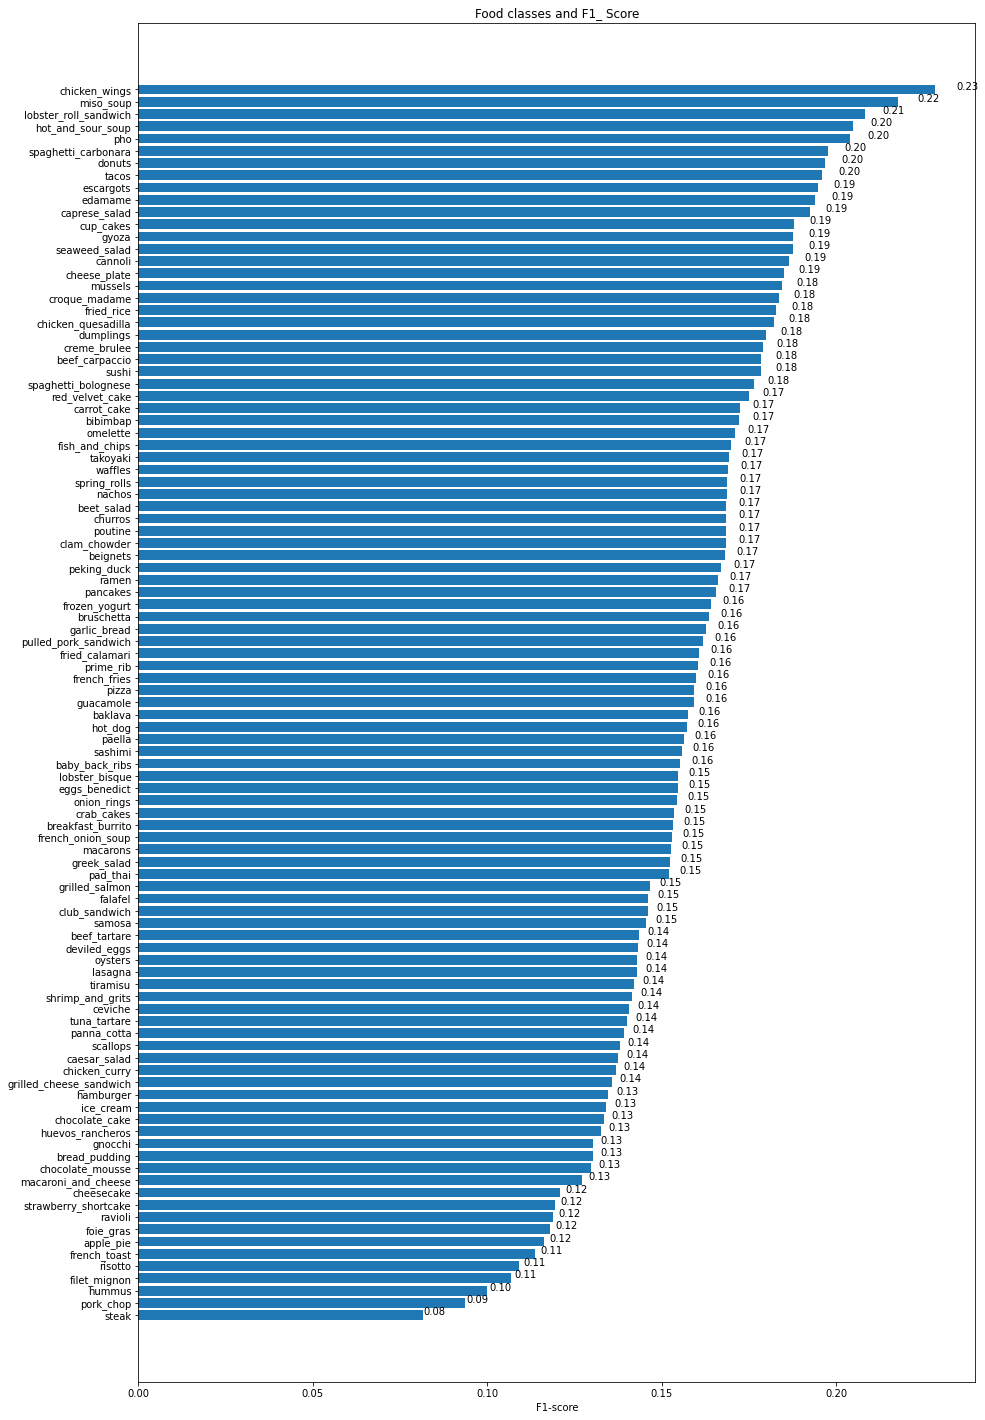

In [71]:
### Plotting our Classification report in Horizontal Barchart

fig, ax = plt.subplots(figsize = (15, 25))

hbars = ax.barh(f1_scores['class_name'], f1_scores['f1-score'])
ax.set_title('Food classes and F1_ Score')
ax.set_xlabel('F1-score')
ax.invert_yaxis()


def autolabel(rects):
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.04*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')
    
autolabel(hbars)
plt.show();